Heart Failures - ML in healthcare - MLP (MULTI LAYER PERCEPTRON)
===

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
import torch
import torch.nn.functional as F

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


# , precision_score, recall_score, auc, roc_curve, roc_auc_score, accuracy_score, classification_report 

In [152]:
import param
import panel as pn
pn.extension()
import datetime as dt
import importlib
from importlib import reload
from tqdm import tqdm

In [5]:
import graph as gr
import params as par
import py_lib as lib
reload(gr)
reload(par)
reload(lib)
import graph as gr
import params as par
import py_lib as lib

In [10]:
format_dict = par.create_format_dict()
format_dict

{'Age': '{:.0f}',
 'RestingBP': '{:.0f}',
 'Cholesterol': '{:.0f}',
 'MaxHR': '{:.0f}',
 'FastingBS': '{:.1f}',
 'HeartDisease': '{:.1f}',
 'Oldpeak': '{:.2f}',
 '0': '{:.0%}',
 '1': '{:.0%}',
 'Accuracy': '{:.1%}',
 'Balanced Accuracy': '{:.1%}',
 'F1 Score': '{:.1%}'}

# Local Parameters

In [11]:
class NotebookParams(param.Parameterized):
    lambda_multiple          = param.Number(1, bounds=(1,10), doc="lambda Lasso Multiple of 10^x")
    n_nodes                  = param.Integer(default=20, bounds=(1,100),doc="Number of nodes in hidden layer")
    lambda_power             = param.Integer(default=2, bounds=(1,7),doc="lambda Lasso exponent of 10^x")
    lr_multiple              = param.Number(5, bounds=(1,10), doc="Learning Rate Multiple of 10^x")
    lr_power                 = param.Integer(default=3, bounds=(1,9),doc="Learning Rate exponent of 10^x")
    epochs                   = param.Integer(default=2000 ,bounds=(5,2000))
    data_set                 = param.ObjectSelector(default="test",objects=['train', 'validation', 'train + validation', 'test'])
    stand_features           = param.Boolean(True, doc="Whether we want to standardize numerical features")
    stand_embeddings         = param.Boolean(False, doc="Whether we want to standardize embeddings")
    use_lasso                = param.Boolean(False)
    use_focal_loss           = param.Boolean(True)
    iter_array               = param.Integer(default=5, bounds=(1,20),doc="How often to save loss and training data, in epochs")
    iter_printing            = param.Integer(default=5, bounds=(1,100),doc="How many epochs between printing")
    add_one_hot_encoded      = param.Boolean(True, doc="Whether to add one hot encoded columns from categorical variables")
    add_embeddings	         = param.Boolean(False, doc="Whether to add embeddings from categorical variables")
    max_emb_dim							 = param.Integer(50, bounds=(10,100),doc="Maximum embedding dimension")
    test_size                = param.Number(0.2, bounds=(0.1,0.9), doc="Test size for train_test_split")
    random_state_test_train_split = param.Integer(42)
base = NotebookParams()

# Import Data

In [12]:
df_heart = pd.read_csv('heart.csv')
df_heart_test = pd.read_csv('test_split.csv')
df_heart_train = pd.read_csv('train_val_split.csv')

In [13]:
df_heart.head(2)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1


# Features Preprocessing

In [104]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
num_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
label_col = 'HeartDisease'

# Benchmark to be dropped for each categorical variable
category_to_drop = {
    'Sex': 'F',
    'ChestPainType': 'ASY',
    'RestingECG': 'Normal',
    'ExerciseAngina': 'N',
    'ST_Slope': 'Flat'
}

In [105]:
pn.Column(
    pn.Row(base.param.add_embeddings, base.param.add_one_hot_encoded, base.param.stand_features, base.param.stand_embeddings),
    pn.Row(base.param.max_emb_dim, base.param.test_size)
        )

Column
    [0] Row
        [0] Checkbox(name='Add embeddings')
        [1] Checkbox(name='Add one hot encoded', value=True)
        [2] Checkbox(name='Stand features', value=True)
        [3] Checkbox(name='Stand embeddings')
    [1] Row
        [0] IntSlider(end=100, name='Max emb dim', start=10, value=50)
        [1] FloatSlider(end=0.9, name='Test size', start=0.1, value=0.2)

In [106]:
train_test_data, final_categorical_features, all_features, embeddings_output = lib.pre_process_features(
        df_heart_train,
        num_features=num_features,
        categorical_features=categorical_features,
        category_to_drop=category_to_drop,
        label_col=label_col,
        add_embeddings=base.add_embeddings,
        add_one_hot_encoded=base.add_one_hot_encoded,
        stand_features=base.stand_features,
        stand_embeddings=base.stand_embeddings,
        test_size=base.test_size,
        random_state=base.random_state_test_train_split,
        replace_pb_values={
            'Cholesterol': {
                'target_to_replace': 0,
                'replacement_method': 'median',
            }
				},
)
X_train, X_test = train_test_data.tensors['X_train'], train_test_data.tensors['X_test']
y_train, y_test = train_test_data.tensors['y_train'], train_test_data.tensors['y_test']
X_train_df = train_test_data.dataframes['X_train']

Before: Number of rows with problematic value: (141,)
After: Number of rows with problematic value: (0,)
adding One Hot Encoded
['M' 'F']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Up']


## Working with the class imbalance

In [107]:
# From ... https://saturncloud.io/blog/how-to-use-class-weights-with-focal-loss-in-pytorch-for-imbalanced-multiclass-classification/#focal-loss
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
total_samples = len(y_train)

class_weights = []
for count in class_counts:
    weight = 1 / (count / total_samples)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights)

In [108]:
class_weights

[2.2150943396226412, 1.8229813664596275]

# Model Building

In [109]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        loss = (self.alpha[targets.long()] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

With Embeddings (initial implementation)

In [110]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
# From https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

class MLP(torch.nn.Module):
	'''
		Multilayer Perceptron.
	'''

	def __init__(self, emb_dims, n_cont_features, lin_layer_sizes,
			  output_size, emb_dropout, lin_layer_dropouts):
		'''
		Parameters
		----------

		emb_dims: List of two element tuples
			This list will contain a two element tuple for each
			categorical feature. The first element of a tuple will
			denote the number of unique values of the categorical
			feature. The second element will denote the embedding
			dimension to be used for that feature.

		n_cont_features: Integer
			The number of continuous features in the data.

		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		output_size: Integer
			The size of the final output.

		emb_dropout: Float
			The dropout to be used after the embedding layers.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.
		'''
		super().__init__()
    # Embedding layers
		self.emb_layers = torch.nn.ModuleList([torch.nn.Embedding(x, y) for x, y in emb_dims])

		n_embs = sum([y for x, y in emb_dims])
		self.n_embs = n_embs
		self.n_cont_features = n_cont_features

		# Linear Layers
		first_lin_layer = torch.nn.Linear(self.n_embs + self.n_cont_features, 
							  lin_layer_sizes[0])

		self.lin_layers =\
			torch.nn.ModuleList([first_lin_layer] +\
					[torch.nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
						for i in range(len(lin_layer_sizes) - 1)])
    
		for lin_layer in self.lin_layers:
			torch.nn.init.kaiming_normal_(lin_layer.weight.data) # TODO(jpinole): check if necessary

		# Output Layer
		self.output_layer = torch.nn.Linear(lin_layer_sizes[-1], output_size)
		torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

		# # Batch Norm Layers
		# self.first_bn_layer = torch.nn.BatchNorm1d(self.n_cont_features)
		# self.bn_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(size)
		# 																for size in lin_layer_sizes])

		# Dropout Layers
		self.emb_dropout_layer = torch.nn.Dropout(emb_dropout)
		self.droput_layers = torch.nn.ModuleList([torch.nn.Dropout(size)
																	for size in lin_layer_dropouts])
		
		# Sigmoid Activation
		self.sigmoid = torch.nn.Sigmoid()


	def forward(self, cont_data, cat_data):

		if self.n_embs != 0:
			x = [emb_layer(cat_data[:, i])
						for i,emb_layer in enumerate(self.emb_layers)]
			x = torch.cat(x, 1)
			x = self.emb_dropout_layer(x)

		if self.n_cont_features != 0:
			# normalized_cont_data = self.first_bn_layer(cont_data)

			if self.n_embs != 0:
				# x = torch.cat([x, normalized_cont_data], 1) 
				x = torch.cat([x, cont_data], 1) 
			else:
				# x = normalized_cont_data
				x = cont_data

		# for lin_layer, dropout_layer, bn_layer in\
		# 		zip(self.lin_layers, self.droput_layers, self.bn_layers):
		for lin_layer, dropout_layer in\
				zip(self.lin_layers, self.droput_layers):
			x = F.relu(lin_layer(x))
			# x = bn_layer(x)
			x = dropout_layer(x)

		x = self.sigmoid(self.output_layer(x))

		return x

With OHE (final implementation)

In [118]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/
# From https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/

class MLP(torch.nn.Module):
	'''
		Multilayer Perceptron.
	'''

	def __init__(self, emb_dims, n_cont_features, lin_layer_sizes,
			  output_size, emb_dropout, lin_layer_dropouts):
		'''
		Parameters
		----------

		emb_dims: List of two element tuples
			This list will contain a two element tuple for each
			categorical feature. The first element of a tuple will
			denote the number of unique values of the categorical
			feature. The second element will denote the embedding
			dimension to be used for that feature.

		n_cont_features: Integer
			The number of continuous features in the data.

		lin_layer_sizes: List of integers.
			The size of each linear layer. The length will be equal
			to the total number
			of linear layers in the network.

		output_size: Integer
			The size of the final output.

		emb_dropout: Float
			The dropout to be used after the embedding layers.

		lin_layer_dropouts: List of floats
			The dropouts to be used after each linear layer.
		'''
		super().__init__()


		# Linear Layers
		first_lin_layer = torch.nn.Linear(15 ,lin_layer_sizes[0])

		self.lin_layers =\
			torch.nn.ModuleList([first_lin_layer] +\
					[torch.nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
						for i in range(len(lin_layer_sizes) - 1)])
    
		for lin_layer in self.lin_layers:
			torch.nn.init.kaiming_normal_(lin_layer.weight.data) # TODO(jpinole): check if necessary

		# Output Layer
		self.output_layer = torch.nn.Linear(lin_layer_sizes[-1], output_size)
		torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

		# # Batch Norm Layers
		# self.first_bn_layer = torch.nn.BatchNorm1d(self.n_cont_features)
		# self.bn_layers = torch.nn.ModuleList([torch.nn.BatchNorm1d(size)
		# 																for size in lin_layer_sizes])

		# Dropout Layers
		self.emb_dropout_layer = torch.nn.Dropout(emb_dropout)
		self.droput_layers = torch.nn.ModuleList([torch.nn.Dropout(size)
																	for size in lin_layer_dropouts])
		
		# Sigmoid Activation
		self.sigmoid = torch.nn.Sigmoid()


	def forward(self, cont_data):
		x = cont_data
		# for lin_layer, dropout_layer, bn_layer in\
		# 		zip(self.lin_layers, self.droput_layers, self.bn_layers):
		for lin_layer, dropout_layer in\
				zip(self.lin_layers, self.droput_layers):
			x = F.relu(lin_layer(x))
			# x = bn_layer(x)
			x = dropout_layer(x)

		x = self.sigmoid(self.output_layer(x))

		return x

# Training

In [119]:
pn.Column(
    pn.Row(base.param.use_lasso, base.param.use_focal_loss),
    pn.Row(base.param.lr_power, base.param.lr_multiple),
    pn.Row(base.param.lambda_power, base.param.lambda_multiple)
    )

Column
    [0] Row
        [0] Checkbox(name='Use lasso')
        [1] Checkbox(name='Use focal loss', value=True)
    [1] Row
        [0] IntSlider(end=9, name='Lr power', start=1, value=3)
        [1] FloatSlider(end=10, name='Lr multiple', start=1, value=5)
    [2] Row
        [0] IntSlider(end=7, name='Lambda power', start=1, value=2)
        [1] FloatSlider(end=10, name='Lambda multiple', start=1, value=1)

In [120]:
lr = base.lr_multiple * 10**(-base.lr_power)
print('learning rate is {} multiplied by 10 power {}, which yields {:.8f}'.format(base.lr_multiple, -base.lr_power, lr))
lambda_lasso = base.lambda_multiple * 10**(-base.lambda_power)
print('lambda_lasso is {} multiplied by 10 power {}, which yields {:.6f}'.format(base.lambda_multiple, -base.lambda_power, lambda_lasso))

learning rate is 5 multiplied by 10 power -3, which yields 0.00500000
lambda_lasso is 1 multiplied by 10 power -2, which yields 0.010000


In [121]:
pn.Column(
    pn.Row(base.param.epochs, base.param.iter_array, base.param.iter_printing),
    )

Column
    [0] Row
        [0] IntSlider(end=2000, name='Epochs', start=5, value=2000)
        [1] IntSlider(end=20, name='Iter array', start=1, value=5)
        [2] IntSlider(end=100, name='Iter printing', start=1, value=5)

In [122]:
input_dim = len(num_features + final_categorical_features)
output_dim = 1 # Single binary output
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(
	emb_dims=embeddings_output['emb_dims'],
	n_cont_features=len(num_features),
	lin_layer_sizes=[50,100],
	output_size=1,
	emb_dropout=0.04,
	lin_layer_dropouts=[0.001, 0.01],
    ).to(device)
if base.use_focal_loss:
    criterion = FocalLoss(alpha=class_weights_tensor.long(), gamma=2)
else:
    criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
iter_printing_effective = int(base.epochs/base.iter_printing)
print('iter_printing_effective is {}'.format(iter_printing_effective))
# torch.manual_seed(0) # keep things reproducible

iter_printing_effective is 400


In [123]:
X_train['all'].shape

torch.Size([587, 15])

In [124]:
losses = []
losses_test = []
Iterations = []
iter = 0
model.train()
for epoch in tqdm(range(int(base.epochs)),desc='Training Epochs'):
		x = X_train
		labels = y_train
		optimizer.zero_grad() # Setting our stored gradients equal to zero
		# outputs = model(X_train['num'], X_train['cat'])  # Perform forward pass
		outputs = model(X_train['all'])  # Perform forward pass
		loss = criterion(torch.squeeze(outputs), labels) # Compute loss
		loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

		# Compute L1 loss component
		# if base.use_lasso:
		#     loss = add_l1_loss(model, loss, lambda_lasso=lambda_lasso)

		optimizer.step() # Updates weights and biases with the optimizer (SGD)
		
		iter+=1
		if iter%base.iter_array==0:
				with torch.no_grad():
						# Calculating the loss and accuracy for the test dataset
						correct_test = 0
						total_test = 0
						outputs_test = torch.squeeze(model(X_test['all']))
						loss_test = criterion(outputs_test, y_test)
						# loss_test = add_l1_loss(model, loss_test, lambda_lasso=lambda_lasso)
						
						predicted_test = outputs_test.round().detach().numpy()
						total_test += y_test.size(0)
						correct_test += np.sum(predicted_test == y_test.detach().numpy())
						accuracy_test = 100 * correct_test/total_test
						losses_test.append(loss_test.item())
						
						
						# Calculating the loss and accuracy for the train dataset
						total = 0
						correct = 0
						total += y_train.size(0)
						correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
						accuracy = 100 * correct/total
						losses.append(loss.item())
						Iterations.append(iter)

						if iter%iter_printing_effective==0:
								print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
								print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  21%|██        | 412/2000 [00:05<00:21, 72.42it/s] 

Iteration: 400. 
Test - Loss: 0.1452838033437729. Accuracy: 82.99319727891157
Train -  Loss: 0.14931370317935944. Accuracy: 81.60136286201022



Training Epochs:  41%|████      | 821/2000 [00:07<00:05, 211.02it/s]

Iteration: 800. 
Test - Loss: 0.12752939760684967. Accuracy: 83.6734693877551
Train -  Loss: 0.13522060215473175. Accuracy: 84.49744463373084



Training Epochs:  60%|██████    | 1210/2000 [00:10<00:04, 158.90it/s]

Iteration: 1200. 
Test - Loss: 0.12393216788768768. Accuracy: 84.35374149659864
Train -  Loss: 0.12845303118228912. Accuracy: 84.8381601362862



Training Epochs:  81%|████████  | 1618/2000 [00:12<00:01, 212.27it/s]

Iteration: 1600. 
Test - Loss: 0.11695894598960876. Accuracy: 85.03401360544218
Train -  Loss: 0.1284441500902176. Accuracy: 84.8381601362862



Training Epochs: 100%|██████████| 2000/2000 [00:15<00:00, 130.89it/s]

Iteration: 2000. 
Test - Loss: 0.119184210896492. Accuracy: 85.71428571428571
Train -  Loss: 0.1227533221244812. Accuracy: 86.54173764906304



Text(0, 0.5, 'Focal Loss')

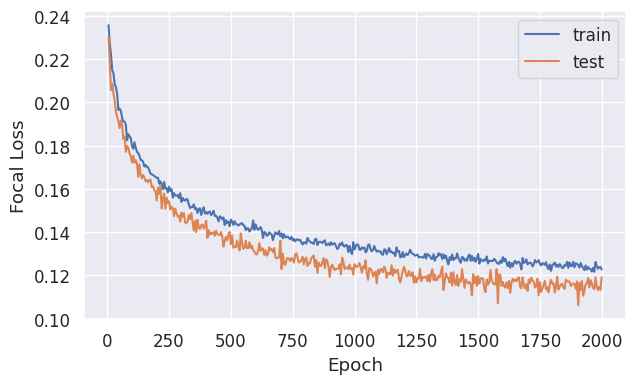

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (7,4))
ax.plot(Iterations,losses, label='train')
ax.plot(Iterations,losses_test, label='test')
ax.legend()
ax.set_xlabel('Epoch')
loss_type = 'Focal Loss' if base.use_focal_loss else 'BCE Loss'
ax.set_ylabel(loss_type)
# fig.show()

# Evaluation

## Predictions performances

In [126]:
pn.Row(base.param.data_set)

Row
    [0] Select(name='Data set', options=OrderedDict([('train', ...]), value='test')

In [127]:
dataset_choice = {
    'train': {
        'data': {
            'x': train_test_data.tensors['X_train']['all'],
            'y': train_test_data.tensors['y_train'],
        },
        'already_processed': True,
    },
    'validation': {
        'data': {
            'x': train_test_data.tensors['X_test']['all'],
            'y': train_test_data.tensors['y_test'],
        },
        'already_processed': True,
    },
    'train + validation': {
        'data': df_heart_train,
        'already_processed': False,
    },
    'test': {
        'data': df_heart_test,
        'already_processed': False,
    },
    'all': {
        'data': df_heart,
        'already_processed': False,
    },
}
print('We are displaying evaluation over the {} dataset'.format(base.data_set.upper()))
data_specs = dataset_choice[base.data_set]

We are displaying evaluation over the TEST dataset


In [128]:
if data_specs['already_processed']:
    print('Data were already processed for training.')
    x_features = data_specs['data']['x'] # A dictionary
    y_true = data_specs['data']['y']
else:
        print('Processing data')
        processed_data, _, _, _ = lib.pre_process_features(
                data_specs['data'],
                num_features=num_features,
                categorical_features=categorical_features,
                category_to_drop=category_to_drop,
                label_col=label_col,
                add_one_hot_encoded=base.add_one_hot_encoded,
                add_embeddings=base.add_embeddings,
                stand_features=base.stand_features,
        				stand_embeddings=base.stand_embeddings,
                test_size=base.test_size,
                random_state=base.random_state_test_train_split,
                split_data=False,
								replace_pb_values={
										'Cholesterol': {
												'target_to_replace': 0,
												'replacement_method': 'median',
										}
								},
        )
        x_features = processed_data.tensors['X_train'] # Now importing a dictionary
        y_true = processed_data.tensors['y_train']

Processing data
Before: Number of rows with problematic value: (31,)
After: Number of rows with problematic value: (0,)
adding One Hot Encoded
['M' 'F']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Up']


In [129]:
model.eval()
y_pred_tensor = torch.squeeze(model(x_features['all']))
y_pred_round_tensor = y_pred_tensor.round()
y_pred = y_pred_tensor.detach().numpy()
y_pred_round = y_pred_round_tensor.detach().numpy()

In [130]:
from torchmetrics.classification import BinaryF1Score
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc = accuracy_score(y_true, y_pred_round, normalize = True)  
bal_acc=balanced_accuracy_score(y_true,y_pred_round)
f1_score = BinaryF1Score()
f1 = f1_score(y_pred_round_tensor, y_true).numpy()
summary_metrics = pd.DataFrame(data=[acc, bal_acc, f1], index=['Accuracy', 'Balanced Accuracy', 'F1 Score'], columns=['metrics']).T

In [133]:
summary_metrics.style.format(format_dict)

,Accuracy,Balanced Accuracy,F1 Score
metrics,82.1%,80.6%,85.5%


Text(0.5, 1.0, 'Confusion Matrix, dataset = test')

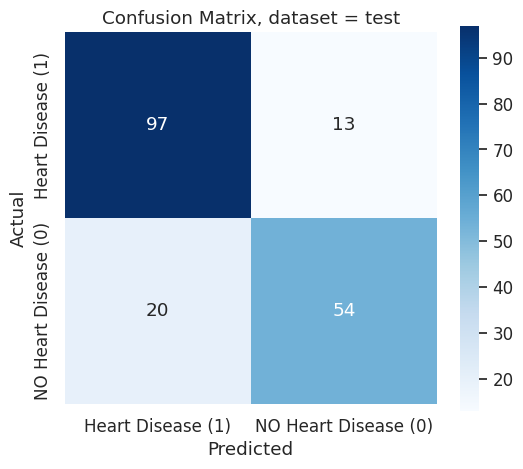

In [132]:
logreg_conf_matrix = confusion_matrix(y_true, y_pred_round)
plt.figure(figsize = (6,5)) 
sns.set(font_scale=1.1) 
ax = sns.heatmap(
    logreg_conf_matrix,
    cmap='Blues',
    annot=True,
    fmt='d',
    square=True,
    xticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'],
    yticklabels=['NO Heart Disease (0)', 'Heart Disease (1)'])
ax.set(xlabel='Predicted', ylabel='Actual')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Confusion Matrix, dataset = {}'.format(base.data_set))

In [134]:
logreg_conf_matrix

array([[54, 20],
       [13, 97]])

In [135]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_performance = auc(fpr, tpr)

/home/pinolej/eth/healthcare/heart/graph.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)
/home/pinolej/eth/healthcare/heart/graph.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals], fontsize=9)


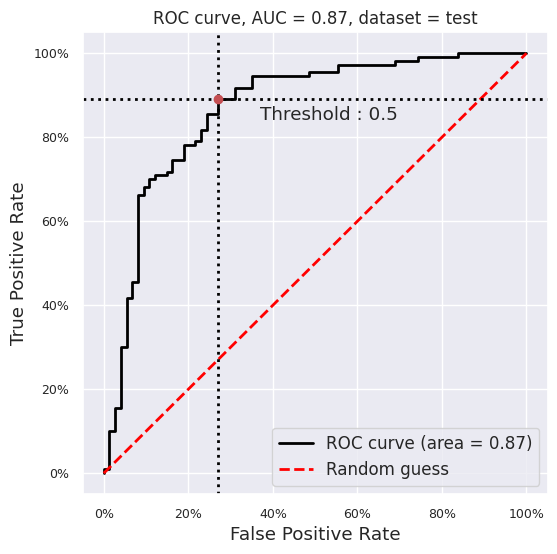

In [136]:
gr.custom_roc_curve(
        fpr,
        tpr,
        thresholds,
        thresholds_to_plot=[0.5],
        figsize=(6,6),
        fontsize={
            'ax_title': 12,
        },
        dataset_type=base.data_set,
        auc_performance=auc_performance,
        y_text_margin=0.05,
        x_text_margin=0.1,
        plot_threshold=True,
)

# Shap

In [90]:
X_train['all'].shape

torch.Size([587, 20])

In [137]:
from torch.autograd import Variable

In [138]:
import tqdm as notebook_tqdm
import shap

In [139]:
f = lambda x: model(Variable(torch.from_numpy(x) )).detach().numpy()
data = X_train['all'].numpy()

# The explainer doesn't like tensors, hence the f function
explainer = shap.KernelExplainer(f, data)
# Get the shap values from my test data



Using 587 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [140]:
data_positive = X_train['all'][:20,:].numpy()
shap_values = explainer.shap_values(data_positive)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:32<00:00,  7.64s/it]


In [143]:
# Enable the plots in jupyter
shap.initjs()

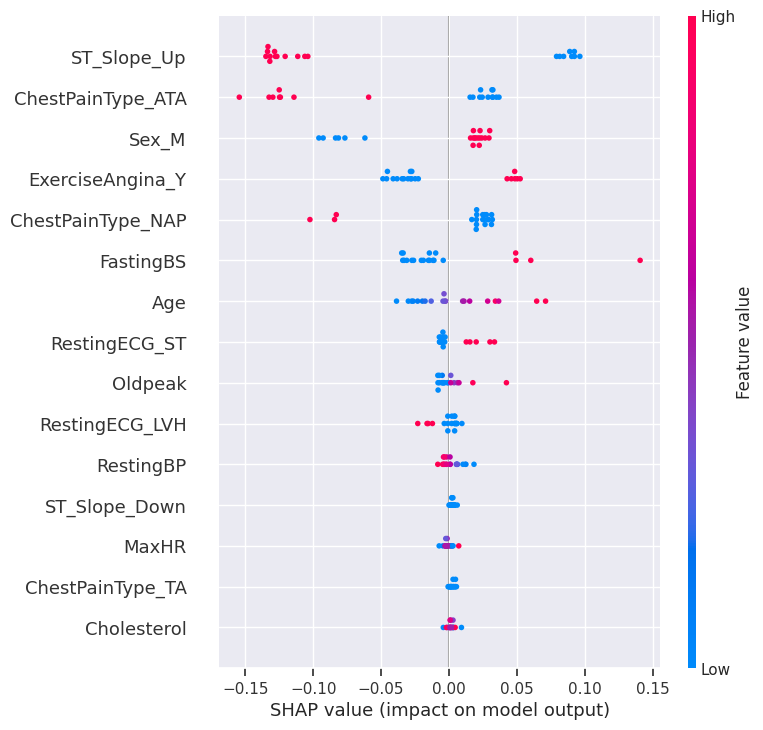

In [144]:
feature_names = all_features
shap.summary_plot(np.squeeze(shap_values, axis=2), data_positive, all_features)

# Appendix

In [43]:
model_2 = torch.nn.Sequential(
    torch.nn.Linear(3, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 1),
)

print(model_2(torch.randn(4, 3))) # feed it 4 random 3-dim. vectors

tensor([[0.3709],
        [0.4930],
        [0.4063],
        [0.3934]], grad_fn=<AddmmBackward0>)


In [ ]:
# class Example(BaseClass):
#     """An example Parameterized class"""
#     timestamps = []

#     boolean                 = param.Boolean(True, doc="A sample Boolean parameter")
#     color                   = param.Color(default='#FFFFFF')
#     date                    = param.Date(dt.datetime(2017, 1, 1),
#                                          bounds=(dt.datetime(2017, 1, 1), dt.datetime(2017, 2, 1)))
#     select_string           = param.ObjectSelector(default="yellow",objects=["red","yellow","green"])
#     select_fn               = param.ObjectSelector(default=list,objects=[list,set,dict])
#     int_list                = param.ListSelector(default=[3,5], objects=[1,3,5,7,9],precedence=0.5)
#     single_file             = param.FileSelector(path='../../*/*.py*',precedence=0.5)
#     multiple_files          = param.MultiFileSelector(path='../../*/*.py?',precedence=0.5)
#     record_timestamp        = param.Action(lambda x: x.timestamps.append(dt.datetime.now()),
#                                            doc="""Record timestamp.""",precedence=0.7)

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        be_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-be_loss)
        print('be loss is {}'.format(be_loss))
        print('pt is {}'.format(pt))
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * be_loss).mean()
        return loss

In [ ]:
# From https://machinelearningmastery.com/building-a-binary-classification-model-in-pytorch/

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [ ]:
class LogisticRegression(torch.nn.Module):
     
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         

     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs
     

     def compute_loss(self, y_pred, y_true):
         return F.binary_cross_entropy(y_pred, y_true)


     def compute_l1_loss(self, w):
         return torch.abs(w).sum()


def add_l1_loss( model, loss, lambda_lasso: float = 0.01):
    # TODO(pinolej): Check whether can be added to the class
    l1_parameters = []
    for parameter in model.parameters():
        l1_parameters.append(parameter.view(-1))
    l1 = lambda_lasso * model.compute_l1_loss(torch.cat(l1_parameters))
    # Add L1 loss component
    loss += l1
    return loss

In [ ]:
# Inspired from https://towardsdatascience.com/the-secret-to-improved-nlp-an-in-depth-look-at-the-nn-embedding-layer-in-pytorch-6e901e193e16

# Define the embedding layer with 10 vocab size and 50 vector embeddings.
embedding = torch.nn.Embedding(10, 50)

embedding(torch.LongTensor([2]))

# Load a pre-trained embedding model
pretrained_embeddings = torch.randn(10, 50) # Example only, not actual pre-trained embeddings

# Initialize the embedding layer with the pre-trained embeddings
embedding.weight.data.copy_(pretrained_embeddings)